<a href="https://colab.research.google.com/github/lixuran/codes-groceries/blob/master/colab_vgg_direct_save_top_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import tensorflow as tf
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import applications

from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Activation,Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# with open('/content/gdrive/My Drive/foo.txt', 'w') as f:
#   f.write('Hello Google Drive!')
# !cat /content/gdrive/My\ Drive/foo.txt
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive2 = GoogleDrive(gauth)

In [0]:

# img_data_list=[]
# classsize = []
# for dataset in data_dir_list:
#     img_list=os.listdir(data_path+'/'+ dataset)
#     classsize.append(len(img_list))
#     print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
#     for img in img_list:
#         img_path = data_path + '/'+ dataset + '/'+ img
#         img = image.load_img(img_path, target_size=(224, 224))
#         x = image.img_to_array(img)
#         x = np.expand_dims(x, axis=0)
#         x = preprocess_input(x)
#         #x = x/255 should we do this in preprocession?
#         #print('Input image shape:', x.shape)
#         img_data_list.append(x)

# # x is the last vector of the image
# #print(x)
# img_data = np.array(img_data_list)
# #img_data = img_data.astype('float32')
# print (img_data.shape)
# img_data=np.rollaxis(img_data,1,0)
# print (img_data.shape)
# img_data=img_data[0]
# print (img_data.shape)


In [84]:

# Define the number of classes change this code condition to the number of classes.
# Loading the training data
PATH = os.getcwd()
print(PATH)
# Define data path
data_path = PATH + '/gdrive/My Drive/sdp/dataset_new'
data_dir_list =['glass', 'metal',  'plastic' ] # LETS  start with the sample version 


#define parameters here
img_width, img_height = 150, 150

top_model_weights_path = 'bottleneck_vgg_model.h5'
train_data_dir = data_path+'/train'
validation_data_dir = data_path+'/validation'

epochs = 80
batch_size = 32

#check dataset size
classsize = []
for dataset in data_dir_list:
    img_list=os.listdir(train_data_dir+'/'+ dataset)
    classsize.append(len(img_list))

#assign labels    
num_classes = 3
train_labels = np.ones((np.sum(classsize),),dtype='int64')
train_labels[0:classsize[0]-1]=0
train_labels[classsize[0]:classsize[0]+classsize[1]-1]=1
train_labels[classsize[0]+classsize[1]:]=2
nb_train_samples = np.sum(classsize)
classsize = []
for dataset in data_dir_list:
    img_list=os.listdir(validation_data_dir+'/'+ dataset)
    classsize.append(len(img_list))
    
test_labels = np.ones((np.sum(classsize),),dtype='int64')
test_labels[0:classsize[0]-1]=0
test_labels[classsize[0]:classsize[0]+classsize[1]-1]=1
test_labels[classsize[0]+classsize[1]:]=2
names = ['glass', 'metal',  'plastic' ]


nb_validation_samples = np.sum(classsize)

# convert class labels to on-hot encoding
Y_train = np_utils.to_categorical(train_labels, num_classes)
Y_test = np_utils.to_categorical(test_labels, num_classes)
# #Shuffle the dataset
# x,y = shuffle(img_data,Y, random_state=2)
# # Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


/content


In [0]:
#########################################################################################
# Custom_vgg_model_1
#Training the classifier alone
# image_input = Input(shape=(224, 224, 3))

# model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')
# model.summary()
# last_layer = model.get_layer('fc2').output
# #x= Flatten(name='flatten')(last_layer)
# out = Dense(num_classes, activation='softmax', name='output')(last_layer)
# custom_vgg_model = Model(image_input, out)
# custom_vgg_model.summary()

# for layer in custom_vgg_model.layers[:-1]:
#     layer.trainable = False

# custom_vgg_model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])


# t=time.time()
# #t = now()
# hist2 = custom_vgg_model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=1, validation_data=(X_test, y_test))
# print('Training time: %s' % (t - time.time()))
# (loss2, accuracy2) = custom_vgg_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

# print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss2,accuracy2 * 100))

from tensorflow.keras.models import Sequential

    #this does not save to google drive, but only to colab directory
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)
#     image_input = Input(shape=(224, 224, 3))
#     model = VGG16(input_tensor=image_input,include_top=False, weights='imagenet')

    # build the VGG16 network
    model = VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(
        generator, nb_train_samples // batch_size)
    np.save(open('bottleneck_features_vgg_train.npy', 'wb'),
            bottleneck_features_train)
    
    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(
        generator, nb_validation_samples // batch_size)
    np.save(open('bottleneck_features_vgg_validation.npy', 'wb'),
            bottleneck_features_validation)

    
    


def train_top_model():
    X_train = np.load(open('bottleneck_features_vgg_train.npy','rb'))
    X_test = np.load(open('bottleneck_features_vgg_validation.npy','rb'))
    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax', name='output'))

    model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

    X_train,y_train = shuffle(X_train,Y_train, random_state=2)
    X_test,y_test = shuffle(X_test,Y_test, random_state=2)
    history=model.fit(X_train, y_train,
              epochs=epochs,
              batch_size=batch_size,
              verbose=1,
              validation_data=(X_test, y_test))
    model.save_weights(top_model_weights_path)
    model.save('vgg16_direct.h5') 
    
    return history


############################################################################################
# visualizing losses and accuracy
def plot_history(history,epochs):
    train_loss2=history.history['loss']
    val_loss2=history.history['val_loss']
    train_acc2=history.history['acc']
    val_acc2=history.history['val_acc']
    xc=range(epochs)
    np.save(open('history_vgg_direct.npy', 'wb'),
                history.history)
    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss2)
    plt.plot(xc,val_loss2)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train_loss vs val_loss')
    plt.grid(True)
    plt.legend(['train','val'])
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc2)
    plt.plot(xc,val_acc2)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train_acc vs val_acc')
    plt.grid(True)
    plt.legend(['train','val'],loc=4)
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

    # this does not save the bottle neck
def save_model_weights_history_to_drive(model_file_name,top_model_weights_path,train_history):
    model_file = drive2.CreateFile({'title' : model_file_name})
    model_file.SetContentFile(model_file_name)
    model_file.Upload()
    # download to google drive
    drive2.CreateFile({'id': model_file.get('id')})

    weight_file = drive2.CreateFile({'title' : top_model_weights_path})
    weight_file.SetContentFile(top_model_weights_path)
    weight_file.Upload()

    # download to google drive
    drive2.CreateFile({'id': weight_file.get('id')})

    history_file = drive2.CreateFile({'title' : train_history})
    history_file.SetContentFile(train_history)
    history_file.Upload()

    # download to google drive
    drive2.CreateFile({'id': history_file.get('id')})
    
    #assuming same top layer structure as in train_top_model. this is stupid as I cant change the hidden layer design,
    #but still leave a reasonable amount of hyperparameter to change considering the amount of computational resource I have
def retrain_layers(top_model_weights_path):

#     # build the VGG16 network
#     model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
#     print('Model loaded.')

#     # build a classifier model to put on top of the convolutional model
#     top_model = Sequential()
#     top_model.add(Flatten(input_shape=model.output_shape[1:]))
#     top_model.add(Dense(256, activation='relu'))

# #     top_model.add(Dense(256, input_shape=model.output_shape[1:],activation='relu'))
#     top_model.add(Dropout(0.5))
#     top_model.add(Dense(num_classes, activation='softmax'))
        
# #     model.add(Flatten(input_shape=X_train.shape[1:]))
# #     model.add(Dropout(0.5))
# #     model.add(Dense(num_classes, activation='softmax', name='output'))
#     # note that it is necessary to start with a fully-trained
#     # classifier, including the top classifier,
#     # in order to successfully do fine-tuning
    input_tensor = Input(shape=(150,150,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(num_classes, activation='softmax'))
    top_model.load_weights(top_model_weights_path)
    model = Model(inputs= base_model.input, outputs= top_model(base_model.output))
#     Model()
#     # add the model on top of the convolutional base
#    model.add(top_model)
    print(model.summary())
    # set the first 15 layers (up to the last conv block)
    # to non-trainable (weights will not be updated)
    # check the model to make sure which block to retrain here.
    for layer in model.layers[:15]:
        layer.trainable = False
    return model
    
    #load the data from the google drive. slow, use only a small portion of gpu power I have. might improve using tf records
def compile_train_transferlearning(model):
      # compile the model with a SGD/momentum optimizer
    # and a very slow learning rate.
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    datagen = ImageDataGenerator(rescale=1. / 255)
    train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False)

    validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    # fine-tune the model
    history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples// batch_size)
    
    return model,history

    #again assuming same top layer structures as in train top model
    #using hyperparameter search by hyperas, not able to change hidden layer is all
def hyperparameter_search(top_model_weights_path):
    input_tensor = Input(shape=(img_width, img_height,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(num_classes, activation='softmax'))
    top_model.load_weights(top_model_weights_path)
    model = Model(inputs= base_model.input, outputs= top_model(base_model.output))
    for layer in model.layers[:15]:
        layer.trainable = False
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                  metrics=['accuracy'])

    datagen = ImageDataGenerator(rescale=1. / 255)
    train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False)

    validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    # fine-tune the model
    history=model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        verbose=1,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples// batch_size)
    
    return model,history


In [5]:
save_bottlebeck_features()

Instructions for updating:
Colocations handled automatically by placer.
Found 11612 images belonging to 3 classes.
Found 2905 images belonging to 3 classes.


In [6]:
history=train_top_model()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 11612 samples, validate on 2905 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
11612/11612 [==============================] - 4s 316us/sample - loss: 0.8687 - acc: 0.6527 - val_loss: 0.6345 - val_acc: 0.7133
Epoch 2/200
11612/11612 [==============================] - 3s 232us/sample - loss: 0.5647 - acc: 0.7663 - val_loss: 0.4537 - val_acc: 0.8182
Epoch 3/200
11612/11612 [==============================] - 3s 233us/sample - loss: 0.4736 - acc: 0.8080 - val_loss: 0.4457 - val_acc: 0.8200
Epoch 4/200
11612/11612 [==============================] - 3s 230us/sample - loss: 0.4127 - acc: 0.8337 - val_loss: 0.4034 - val_acc: 0.8492
Epoch 5/200
11612/11612 [==============================] - 3s 228us/sample - loss: 0.3661 - acc: 0.8598 - val_loss: 0.4106 - val_acc: 0.8513
Epoch 6/200
11612/11612 [==============================] - 3s 232us/sample - loss: 

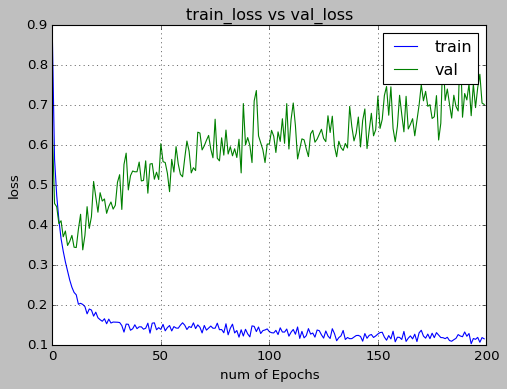

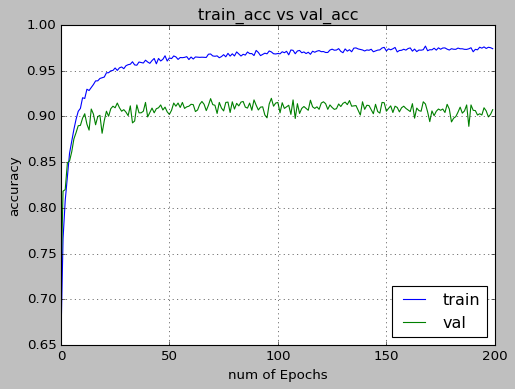

In [12]:
plot_history(history,epochs)
save_model_weights_history('vgg16_direct.h5',top_model_weights_path,'history_vgg_direct.npy')

In [82]:
trained_model =retrain_layers(top_model_weights_path)
#retrained_model,retrain_history=compile_train(trained_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [86]:
#change batch size to make the training faster, can be replaced after loading data to tensorflow records
batch_size=64

retrained_model,retrain_history=compile_train_transferlearning(trained_model)

Found 11612 images belonging to 3 classes.
Found 2905 images belonging to 3 classes.
Epoch 1/80
182/182 [==============================] - 113s 619ms/step - loss: 0.7295 - acc: 0.6920 - val_loss: 0.6462 - val_acc: 0.7298
Epoch 2/80
182/182 [==============================] - 108s 593ms/step - loss: 0.5026 - acc: 0.8055 - val_loss: 0.6922 - val_acc: 0.8200
Epoch 3/80
182/182 [==============================] - 108s 594ms/step - loss: 0.3819 - acc: 0.8595 - val_loss: 0.6958 - val_acc: 0.8799
Epoch 4/80
182/182 [==============================] - 109s 597ms/step - loss: 0.3266 - acc: 0.8891 - val_loss: 0.5839 - val_acc: 0.8988
Epoch 5/80
182/182 [==============================] - 108s 593ms/step - loss: 0.2561 - acc: 0.9196 - val_loss: 0.4581 - val_acc: 0.8826
Epoch 6/80
182/182 [==============================] - 109s 600ms/step - loss: 0.2202 - acc: 0.9264 - val_loss: 0.4091 - val_acc: 0.9091
Epoch 7/80
182/182 [==============================] - 109s 600ms/step - loss: 0.1562 - acc: 0.9532 

In [87]:
def save_all(model,history,model_file_name,top_model_weights_path,train_history):
    model.save_weights(top_model_weights_path)
    model.save(model_file_name) 
    np.save(open(train_history, 'wb'),
                    history.history)
    save_model_weights_history_to_drive(model_file_name,top_model_weights_path,train_history)

save_all(retrained_model,retrain_history,'vgg16_retrain_model.h5',"vgg_retrain_weight.h5",'vgg_retrain_history.npy')

InvalidConfigError: ignored

In [33]:
X_train = np.load(open('bottleneck_features_vgg_train.npy','rb'))
X_train.shape

(11612, 4, 4, 512)

In [63]:
tf.keras.__version__ 

'2.2.4-tf'

In [35]:
model = Sequential()          # create a Keras Model
model.load_weights(top_model_weights_path) 

ValueError: ignored

In [36]:
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
print(top_model.output_shape)
top_model.add(Dense(256, activation='relu'))
print(top_model.output_shape)

top_model.add(Dropout(0.5))
print(top_model.output_shape)

top_model.add(Dense(num_classes, activation='softmax'))
print(top_model.output_shape)


(None, 8192)
(None, 256)
(None, 256)
(None, 3)


In [40]:
base_model.output_shape

(None, 4, 4, 512)